# Classification specificity analysis

This notebook analyzes the specificity of taxonomically classified reads using the cross-species alignment statistics generated from `specificity_analysis.py`. I found that most assigned reads were confidently assigned to their respective species, with less confidence for more related species (e.g. same genus, like *Pseudomonas*) and species that possessed a larger pangenome reference. *Xenorhabdus szentirmaii* showed very low specificity and so was dropped from further functional analysis.

### Workflow:
- Calculate and visualize raw and corrected pairwise alignment specificities/scores between species
- Visualize individual species alignment specificity

***


In [1]:
import sys
from pathlib import Path

root = Path.cwd().parent
sys.path.append(str(root))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src import spec_utils

In [3]:
asi_p = r'raw_data\go_analysis\bowtie2\alignment_similarity.tsv'
ast_p = r'raw_data\go_analysis\bowtie2\alignment_stats.tsv'
asc_p = r'raw_data\go_analysis\bowtie2\alignment_scores.tsv'

In [4]:
asi_df = pd.read_csv(asi_p, sep = '\t', header = 0, index_col = 0)
ast_df = pd.read_csv(ast_p, sep = '\t', header = 0, index_col = 0)
asc_df = pd.read_csv(asc_p, sep = '\t', header = 0, index_col = 0)

asi_df = asi_df.sort_index(axis=0).sort_index(axis=1, ascending = True)
asc_df = asc_df.sort_index(axis=0).sort_index(axis=1, ascending = True)

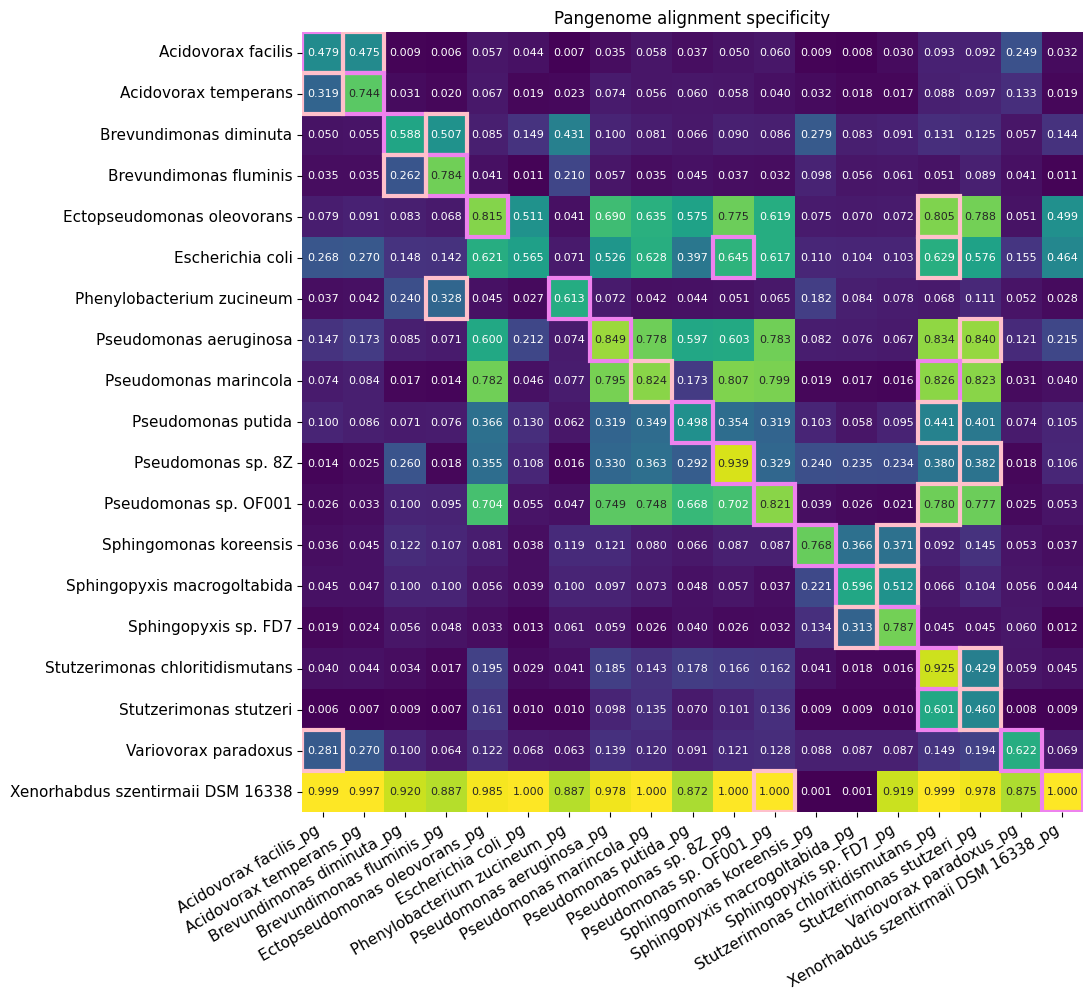

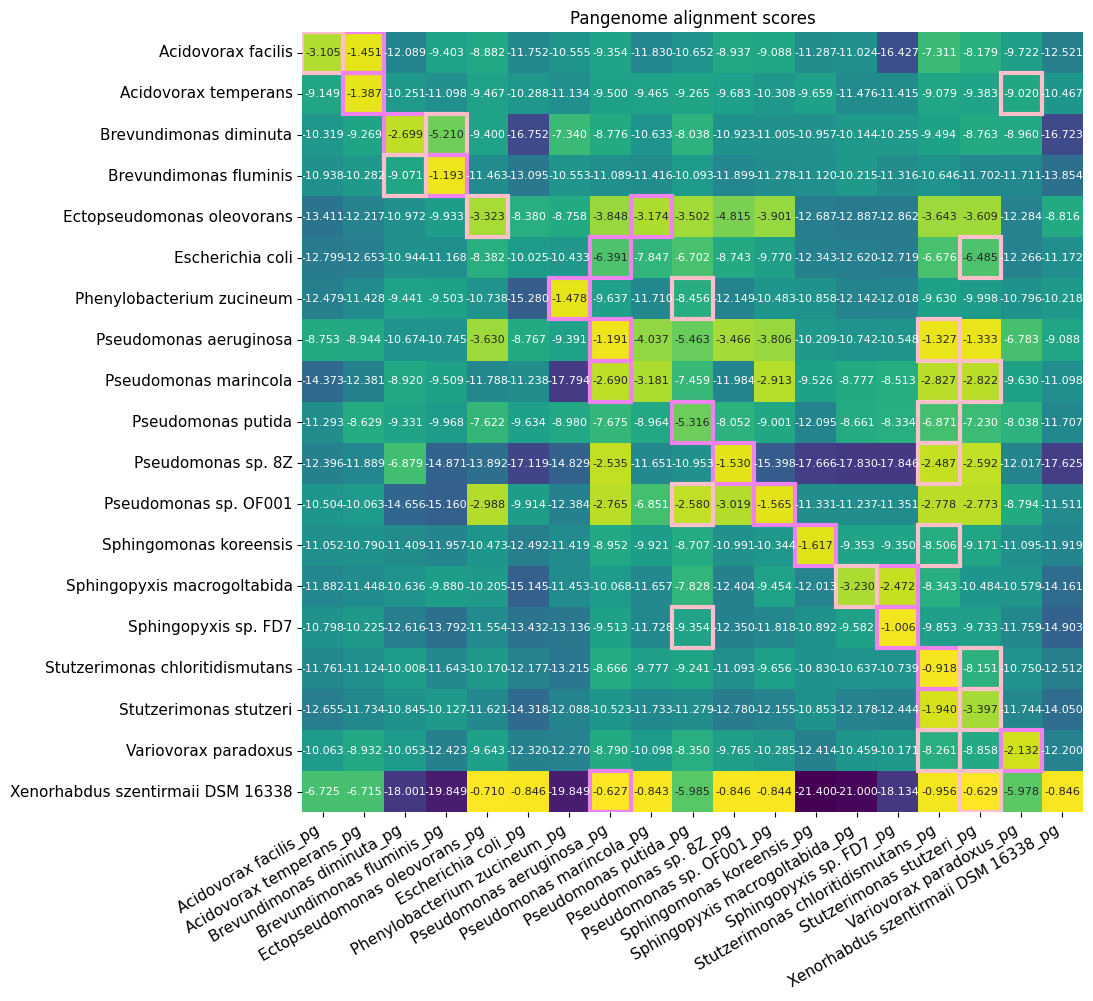

In [ ]:
# visualize alignment similarity and scores
spec_utils.plot_alignment_heatmap(asi_df, 'Pangenome alignment specificity', r'figures\spec_analysis\alignment_similarity.png')
spec_utils.plot_alignment_heatmap(asc_df, 'Pangenome alignment scores', r'figures\spec_analysis\alignment_scores.png')

In [6]:
pg_size_mapping = ast_df['pg_size'].to_dict()
print(pg_size_mapping)

{'Stutzerimonas stutzeri': 500.553, 'Sphingopyxis sp. FD7': 3.54032, 'Ectopseudomonas oleovorans': 63.9365, 'Stutzerimonas chloritidismutans': 163.417, 'Pseudomonas sp. OF001': 7.8371, 'Xenorhabdus szentirmaii DSM 16338': 12.2275, 'Pseudomonas marincola': 30.2089, 'Pseudomonas sp. 8Z': 4.26931, 'Pseudomonas aeruginosa': 2960.87, 'Acidovorax temperans': 23.3184, 'Sphingopyxis macrogoltabida': 10.6541, 'Brevundimonas fluminis': 2.44484, 'Escherichia coli': 3.8358, 'Pseudomonas putida': 332.906, 'Variovorax paradoxus': 57.0835, 'Phenylobacterium zucineum': 3.98753, 'Sphingomonas koreensis': 304.216, 'Brevundimonas diminuta': 56.6054, 'Acidovorax facilis': 8.93421}


In [ ]:
# normalize alignment similarities by species pangenome sizes
asi_norm = spec_utils.normalize(asi_df, pg_size_mapping)

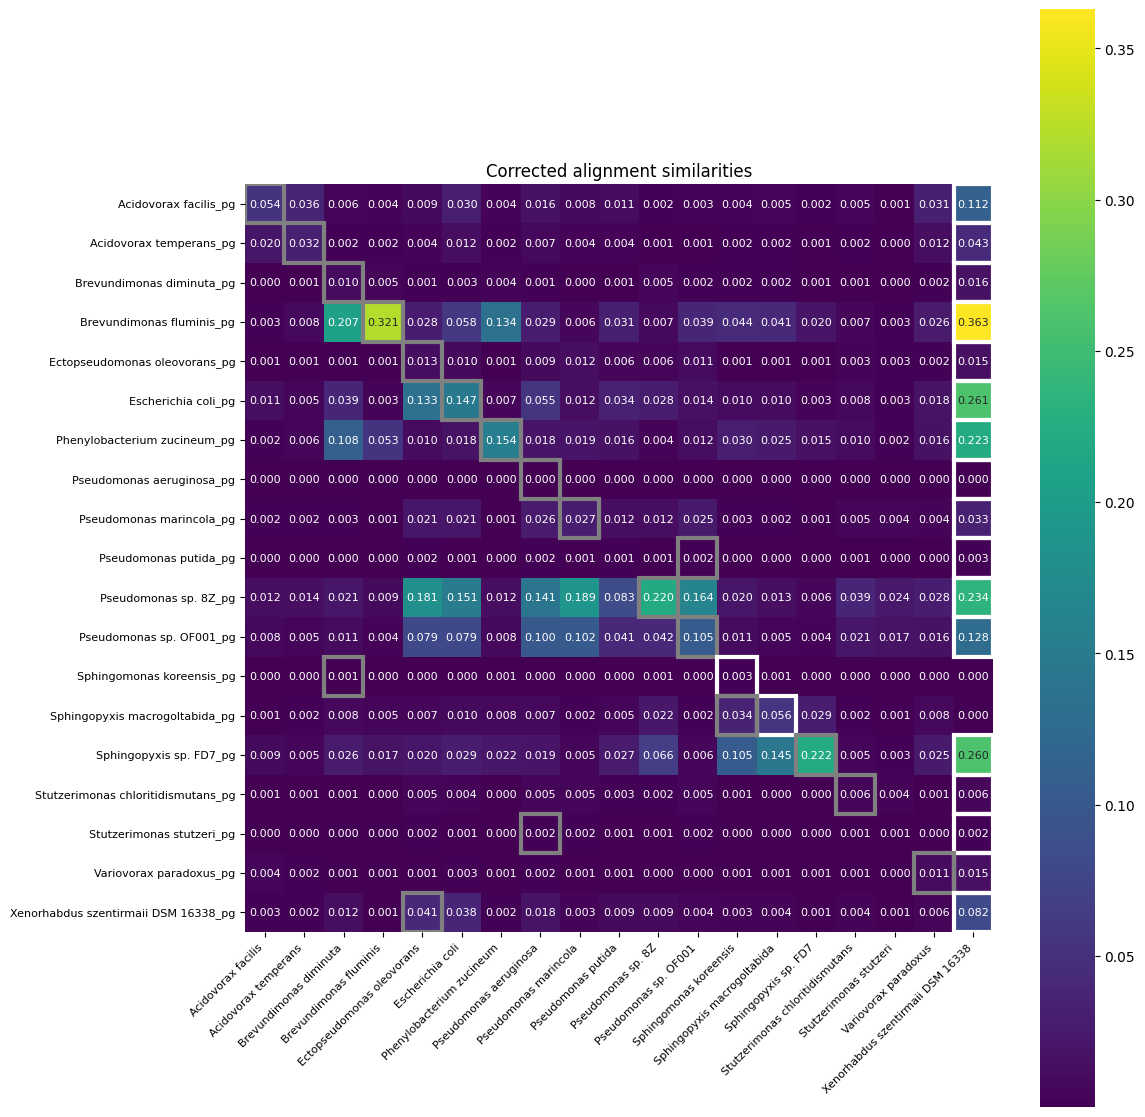

In [ ]:
# visualize corrected values
spec_utils.plot_corrected_heatmap(asi_norm, 'Corrected alignment similarities', r'figures\spec_analysis\cor_alignment_scores.png')

In [ ]:
ast_df.sort_index(axis=0, inplace = True)

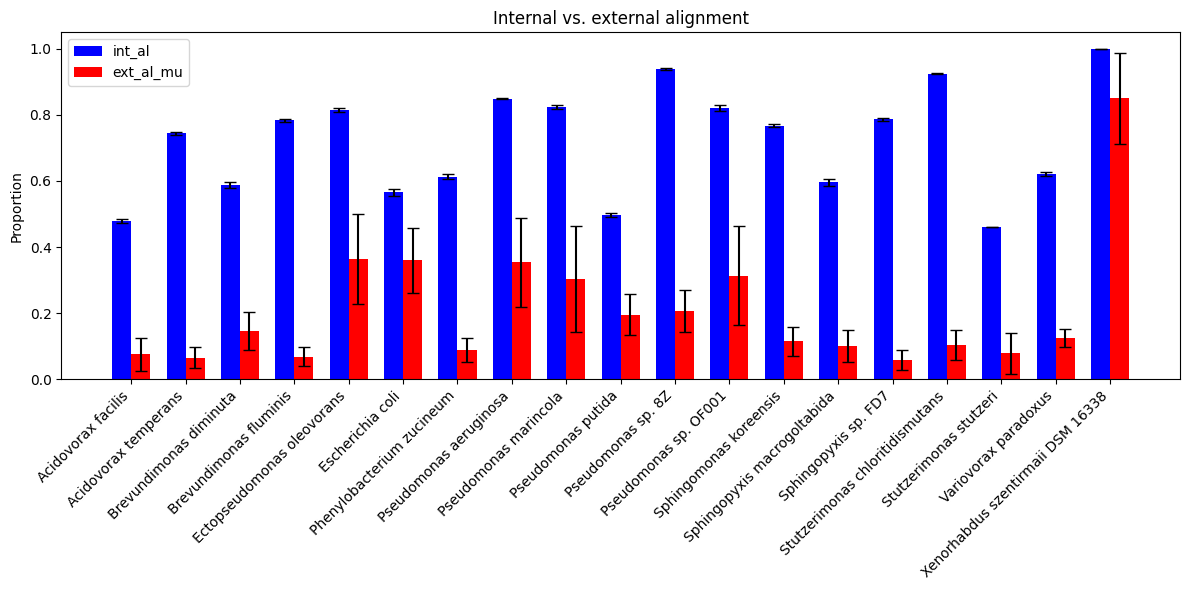

In [ ]:
# internal vs external alignment rates. a higher internal to external alignment rate indicates higher specificity/confidence.
n_int = ast_df['int_unal_ct'] + ast_df['int_al1_ct'] + ast_df['int_al2_ct']
p_int = ast_df['int_al']
se_int = np.sqrt(p_int * (1 - p_int) / n_int)

k_ext = len(ast_df.index)
sd_ext = ast_df['ext_al_std']
sem_ext = sd_ext / np.sqrt(k_ext)

spec_utils.plot_alignment_comparison(ast_df, se_int, sem_ext, r'figures\spec_analysis\int_ext_bp.png')

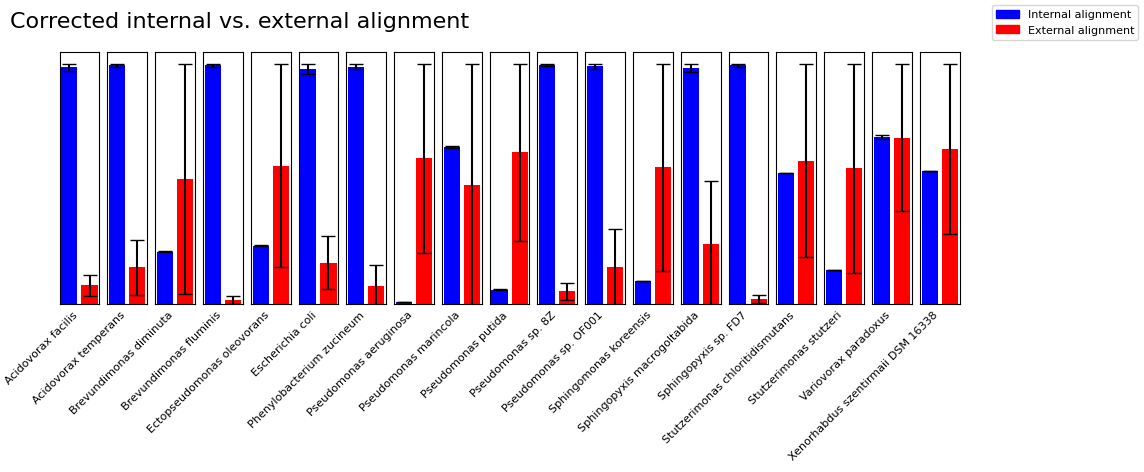

In [ ]:
se_int_cor = se_int / ast_df['pg_size']
yerr_int_cor = 1.96 * se_int_cor

sd_ext_cor = ast_df['ext_al_cor_std']
sem_ext_cor = sd_ext_cor / np.sqrt(k_ext)
yerr_ext_cor = 1.96 * sem_ext_cor

spec_utils.plot_corrected_alignment_subplots(ast_df, yerr_int_cor, yerr_ext_cor, r'figures\spec_analysis\int_ext_cor_bps.png')

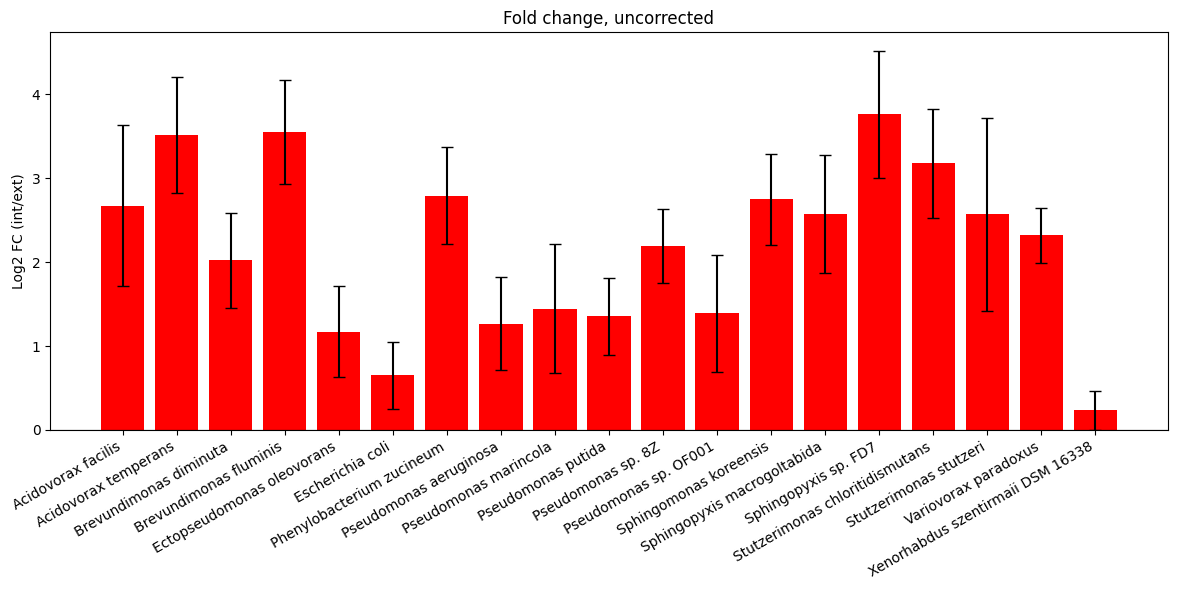

In [ ]:
# visualization of the log2fc values from plots before. a higher log2fc indicates higher specificity/confidence.
ast_df_sorted = ast_df.sort_index()

log2_fc, yerr_log2fc = spec_utils.calculate_log2_fc(ast_df, se_int, sem_ext)
ast_df_sorted['log2_fc'] = log2_fc

spec_utils.plot_log2_fc(ast_df_sorted, log2_fc, yerr_log2fc, 'Fold change, uncorrected', r'figures\spec_analysis\int_ext_fc_uncor.png')


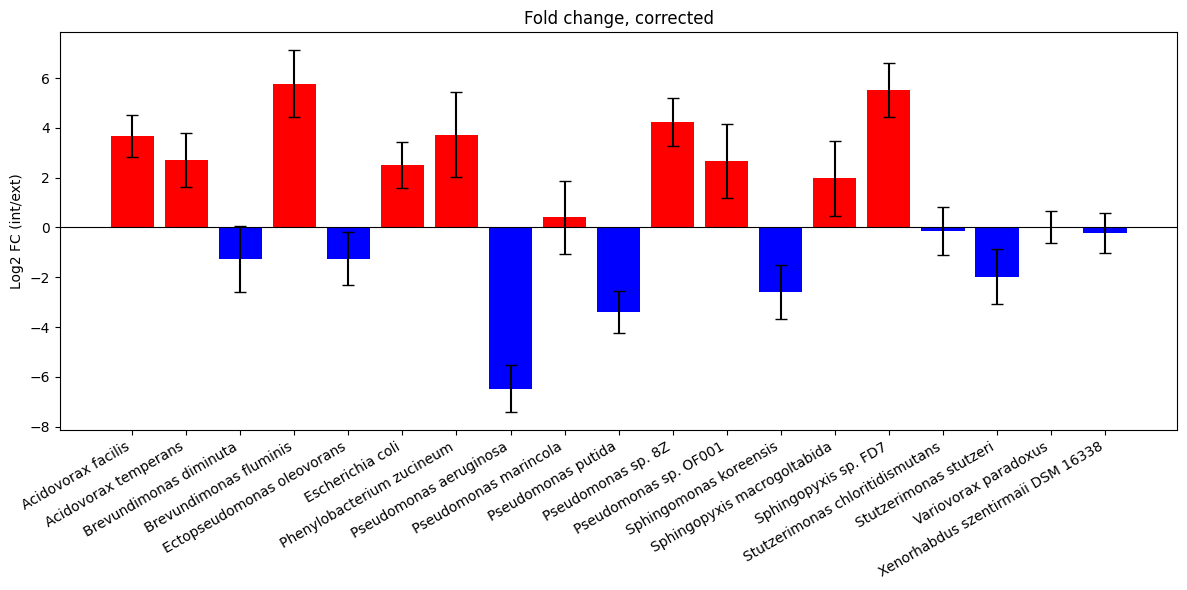

In [13]:
log2_fc_cor, yerr_log2fc_cor = spec_utils.calculate_log2_fc(ast_df, se_int_cor, sem_ext_cor, 'int_al_cor', 'ext_al_cor_mu')
ast_df['log2_fc'] = log2_fc_cor

spec_utils.plot_log2_fc(ast_df, log2_fc_cor, yerr_log2fc_cor, 'Fold change, corrected', r'figures\spec_analysis\int_ext_fc_cor.png')
